In [1]:
import numpy as np
import utils
import matplotlib.pyplot as plt
from task2a import cross_entropy_loss, BinaryModel, pre_process_images
np.random.seed(0)

In [2]:
def gradient_approximation_test(model: BinaryModel, X: np.ndarray, Y: np.ndarray):
    """
        Numerical approximation for gradients. Should not be edited. 
        Details about this test is given in the appendix in the assignment.
    """
    w_orig = np.random.normal(loc=0, scale=1/model.w.shape[0]**2, size=model.w.shape)
    epsilon = 1e-3
    for i in range(w_orig.shape[0]):
        model.w = w_orig.copy()
        orig = w_orig[i].copy()
        model.w[i] = orig + epsilon
        logits = model.forward(X)
        cost1 = cross_entropy_loss(Y, logits)
        model.w[i] = orig - epsilon
        logits = model.forward(X)
        cost2 = cross_entropy_loss(Y, logits)
        gradient_approximation = (cost1 - cost2) / (2 * epsilon)
        model.w[i] = orig
        # Actual gradient
        logits = model.forward(X)
        model.backward(X, logits, Y)
        difference = gradient_approximation - model.grad[i, 0]
        assert abs(difference) <= epsilon**2,\
            f"Calculated gradient is incorrect. " \
            f"Approximation: {gradient_approximation}, actual gradient: {model.grad[i,0]}\n" \
            f"If this test fails there could be errors in your cross entropy loss function, " \
            f"forward function or backward function"

In [3]:
# NO NEED TO CHANGE THIS CODE


class BaseTrainer:

    def __init__(
            self,
            model,
            learning_rate: float,
            batch_size: int,
            shuffle_dataset: bool,
            X_train: np.ndarray, Y_train: np.ndarray,
            X_val: np.ndarray, Y_val: np.ndarray,) -> None:
        """
            Initialize the trainer responsible for performing the gradient descent loop.
        """
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_val = X_val
        self.Y_val = Y_val
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = model
        self.shuffle_dataset = shuffle_dataset

    def validation_step(self):
        """
        Perform a validation step to evaluate the model at the current step for the validation set.
        Also calculates the current accuracy of the model on the train set.
        Returns:
            loss (float): cross entropy loss over the whole dataset
            accuracy_ (float): accuracy over the whole dataset
        Returns:
            loss value (float) on batch
        """
        pass

    def train_step(self):
        """
            Perform forward, backward and gradient descent step here.
        Args:
            X: one batch of images
            Y: one batch of labels
        Returns:
            loss value (float) on batch
        """
        pass

    def train(
            self,
            num_epochs: int):
        """
        Training loop for model.
        Implements stochastic gradient descent with num_epochs passes over the train dataset.
        Returns:
            train_history: a dictionary containing loss and accuracy over all training steps
            val_history: a dictionary containing loss and accuracy over a selected set of steps
        """
        # Utility variables
        num_batches_per_epoch = self.X_train.shape[0] // self.batch_size
        num_steps_per_val = num_batches_per_epoch // 5
        # A tracking value of loss over all training steps
        train_history = dict(
            loss={},
            accuracy={}
        )
        val_history = dict(
            loss={},
            accuracy={}
        )
        lowest_val_loss = np.inf
        es_stop_counter = 0
        global_step = 0
        for epoch in range(num_epochs):
            train_loader = utils.batch_loader(
                self.X_train, self.Y_train, self.batch_size, shuffle=self.shuffle_dataset)
            for X_batch, Y_batch in iter(train_loader):
                loss = self.train_step(X_batch, Y_batch)
                # Track training loss continuously
                train_history["loss"][global_step] = loss

                # Track validation loss / accuracy every time we progress 20% through the dataset
                if global_step % num_steps_per_val == 0:
                    val_loss, accuracy_train, accuracy_val = self.validation_step()
                    train_history["accuracy"][global_step] = accuracy_train
                    val_history["loss"][global_step] = val_loss
                    val_history["accuracy"][global_step] = accuracy_val
                    
                    #Early Stop
                    if val_loss < lowest_val_loss:
                        lowest_val_loss = val_loss
                        es_stop_counter = 0
                        
                    if es_stop_counter >= 10:
                        print("Early stopping at epoch", epoch)
                        return train_history, val_history
                    
                    es_stop_counter += 1
                        
                        
                global_step += 1
        return train_history, val_history


In [4]:
def calculate_accuracy(X: np.ndarray, targets: np.ndarray, model: BinaryModel) -> float:
    """
    Args:
        X: images of shape [batch size, 785]
        targets: labels/targets of each image of shape: [batch size, 1]
        model: model of class BinaryModel
    Returns:
        Accuracy (float)
    """
    # TODO Implement this function (Task 2c)
    output = model.forward(X)
    results = np.abs(targets-output) < 0.5
    count = np.count_nonzero(a=results)
    accuracy = count/X.shape[0]
    return accuracy

In [5]:
class LogisticTrainer(BaseTrainer):

    def train_step(self, X_batch: np.ndarray, Y_batch: np.ndarray):
        """
        Perform forward, backward and gradient descent step here.
        The function is called once for every batch (see trainer.py) to perform the train step.
        The function returns the mean loss value which is then automatically logged in our variable self.train_history.

        Args:
            X: one batch of images
            Y: one batch of labels
        Returns:
            loss value (float) on batch
        """
        output = self.model.forward(X_batch)
        self.model.backward(X_batch, output, Y_batch)
        self.model.w -= self.learning_rate * self.model.grad

        loss = cross_entropy_loss(Y_batch, output)
        return loss

    def validation_step(self):
        """
        Perform a validation step to evaluate the model at the current step for the validation set.
        Also calculates the current accuracy of the model on the train set.
        Returns:
            loss (float): cross entropy loss over the whole dataset
            accuracy_ (float): accuracy over the whole dataset
        Returns:
            loss value (float) on batch
        """
        # NO NEED TO CHANGE THIS FUNCTION
        logits = self.model.forward(self.X_val)
        loss = cross_entropy_loss(Y_val, logits)

        accuracy_train = calculate_accuracy(
            X_train, Y_train, self.model)
        accuracy_val = calculate_accuracy(
            X_val, Y_val, self.model)
        return loss, accuracy_train, accuracy_val

Train shape: X: (4005, 784), Y: (4005, 1)
Validation shape: X: (2042, 784), Y: (2042, 1)
Early stopping at epoch 33
Final Train Cross Entropy Loss: [0.07088706]
Final Validation Cross Entropy Loss: [0.06577188]
Train accuracy: 0.9757802746566792
Validation accuracy: 0.9794319294809011


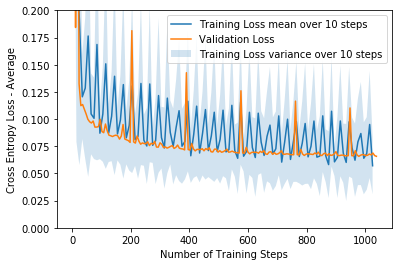

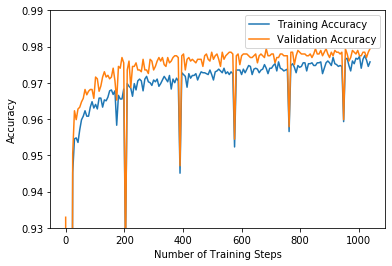

Early stopping at epoch 23


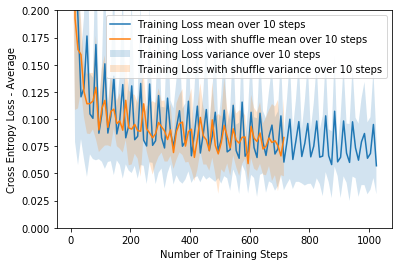

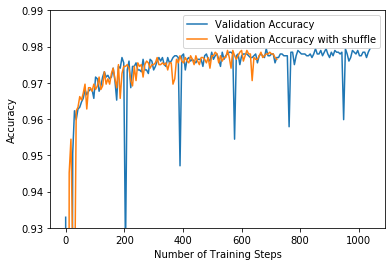

In [7]:
if __name__ == "__main__":
    # hyperparameters DO NOT CHANGE IF NOT SPECIFIED IN ASSIGNMENT TEXT
    num_epochs = 50
    learning_rate = 0.05
    batch_size = 128
    shuffle_dataset = False

    # Load dataset
    category1, category2 = 2, 3
    X_train, Y_train, X_val, Y_val = utils.load_binary_dataset(
        category1, category2)

    X_train = pre_process_images(X_train)
    X_val = pre_process_images(X_val)

    # ANY PARTS OF THE CODE BELOW THIS CAN BE CHANGED.

    # Intialize model
    model = BinaryModel()
    # Train model
    trainer = LogisticTrainer(
        model, learning_rate, batch_size, shuffle_dataset,
        X_train, Y_train, X_val, Y_val,
    )
    train_history, val_history = trainer.train(num_epochs)

    # Plot and print everything you want of information

    print("Final Train Cross Entropy Loss:",
          cross_entropy_loss(Y_train, model.forward(X_train)))
    print("Final Validation Cross Entropy Loss:",
          cross_entropy_loss(Y_val, model.forward(X_val)))
    print("Train accuracy:", calculate_accuracy(X_train, Y_train, model))
    print("Validation accuracy:", calculate_accuracy(X_val, Y_val, model))

    # Plot loss for first model (task 2b)
    plt.ylim([0., .2])
    utils.plot_loss(train_history["loss"],
                    "Training Loss", npoints_to_average=10)
    utils.plot_loss(val_history["loss"], "Validation Loss")
    plt.legend()
    plt.xlabel("Number of Training Steps")
    plt.ylabel("Cross Entropy Loss - Average")
    plt.savefig("task2b_binary_train_loss.png")
    plt.show()

    # Plot accuracy
    plt.ylim([0.93, .99])
    utils.plot_loss(train_history["accuracy"], "Training Accuracy")
    utils.plot_loss(val_history["accuracy"], "Validation Accuracy")
    plt.xlabel("Number of Training Steps")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig("task2b_binary_train_accuracy.png")
    plt.show()

    # Task 2e - Create a comparison between training with and without shuffling
    shuffle_dataset = True
    # Intialize model
    model = BinaryModel()
    # Train model
    trainer = LogisticTrainer(
        model, learning_rate, batch_size, shuffle_dataset,
        X_train, Y_train, X_val, Y_val,
    )
    train_history_shuffle, val_history_shuffle = trainer.train(num_epochs)

    plt.ylim([0., .2])
    utils.plot_loss(train_history["loss"],
                    "Training Loss", npoints_to_average=10)
    utils.plot_loss(
        train_history_shuffle["loss"], "Training Loss with shuffle", npoints_to_average=10)
    plt.legend()
    plt.xlabel("Number of Training Steps")
    plt.ylabel("Cross Entropy Loss - Average")
    plt.savefig("task2e_train_loss_with_shuffle.png")
    plt.show()

    plt.ylim([0.93, .99])
    utils.plot_loss(val_history["accuracy"], "Validation Accuracy")
    utils.plot_loss(
        val_history_shuffle["accuracy"], "Validation Accuracy with shuffle")
    plt.xlabel("Number of Training Steps")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig("task2e_train_accuracy_shuffle_difference.png")
    plt.show()
